In [ ]:
!git clone https://github.com/neuroailab/lr-identify
%cd lr-identify

Cloning into 'lr-identify'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 44 (delta 8), reused 34 (delta 4), pack-reused 0
Unpacking objects: 100% (44/44), done.
/content/lr-identify


In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
!bash get_dataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  511M  100  511M    0     0  37.3M      0  0:00:13  0:00:13 --:--:-- 41.1M


In [ ]:
data = pickle.load(open('dataset.pkl', 'rb'), encoding='latin1')

In [ ]:
data.keys()

dict_keys(['Y', 'X', 'X_cat', 'meta', 'obs_keys'])

# **Trajectory Subsampling**

In [ ]:
traj_origin = np.arange(0, 21, 1)
slice_inter = slice(0, 21, 3)
slice_sparse = slice(0, 21, 5)

traj_dense = traj_origin
traj_inter = traj_origin[slice_inter]
traj_sparse = traj_origin[slice_sparse]

In [ ]:
num_sample = [2, 4, 6, 9, 11, 13, 16, 18, 21]
X = data['X']

i_idx = np.arange(X.shape[0])
z_idx = np.arange(X.shape[2])

def subsamplingX(traj_list, X_sub):
  for idx, num in enumerate(num_sample):
    j_idx = traj_list[0:num]
    if len(j_idx)==num: 
      i,j,z = np.ix_(i_idx, j_idx, z_idx)
      X_sub[idx] = X[i, j, z]
  return X_sub

In [ ]:
traj_dense = traj_origin
traj_inter = traj_origin[slice_inter]
traj_sparse = traj_origin[slice_sparse]

X_dense = {}
X_inter = {}
X_sparse = {}

X_dense = subsamplingX(traj_dense, X_dense)
X_inter = subsamplingX(traj_inter, X_inter)
X_sparse = subsamplingX(traj_sparse, X_sparse)

In [ ]:
data_dense = {}
data_inter = {}
data_sparse = {}

def constructData(X_sub, data_dict):
  for key, value in X_sub.items():
    data_copy = data.copy()
    data_copy.pop('X')
    data_copy['X'] = value
    data_dict[key] = data_copy
  return data_dict

data_dense = constructData(X_dense, data_dense)
data_inter = constructData(X_inter, data_inter)
data_sparse = constructData(X_sparse, data_sparse)

In [ ]:
### Train/test Filter
#
learning_rules = ['adam', 'sgdm', 'information', 'feedback']
task_filter = ['audionet', 'cifar10', 'imagenet', 'simclr']
cls_filter = lambda x: (x['learning_rule'] in learning_rules) and (x['task'] in task_filter)

In [ ]:
from cross_validation import get_possible_inds

cls_filter_first_lr = lambda x: (x['learning_rule'] == learning_rules[0]) and (x['task'] in task_filter)
cls_filter_first_lr_indices = get_possible_inds(data['meta'], cls_filter_first_lr)

In [ ]:
num_total_per_class = len(cls_filter_first_lr_indices)
num_total_examples =  num_total_per_class * len(learning_rules)
# sanity check for category balanced data
assert(num_total_examples == len(get_possible_inds(data['meta'], cls_filter)))
# now we compute num per class train and test
train_frac = 0.75
num_per_class_train = (int)(np.ceil(train_frac*num_total_per_class))
num_per_class_test = num_total_per_class - num_per_class_train

In [ ]:
from fit_pipeline import PipelineClassifier
from functools import partial

classifier_type = partial(PipelineClassifier, estimators=[('cls', 'randomforest')]) # create a classifier - random forest
cv_param_grid = {'cls__max_features': ['sqrt', 'log2'], 'cls__n_estimators': [20, 50]}

**Start Training**

In [ ]:
from fit_pipeline import ObsClassifier

def trajSubsamplingTrain(data_sub, cls_out_test_acc_dict, mark):
  for key in cls_out_test_acc_dict.keys():
    print(mark+" Subsampling Training on "+key+" start." )
    test_acc_list = cls_out_test_acc_dict[key]
    for d_key, d_sub in data_sub.items():
      print("Index "+str(d_key)+", start.")
      cls_out_sub = ObsClassifier(
                      classifier_type=classifier_type, # 'randomforest' in this case
                      num_splits=10, # number of train/test splits
                      num_per_class_train=num_per_class_train, 
                      num_per_class_test=num_per_class_test,
                      train_filter=cls_filter,
                      test_filter=cls_filter, 
                      data=d_sub, # the subsampled data
                      cls_dataset_transform_kwargs={'obs_measure': key, 'num_dims': 2},
                      cv_param_grid=cv_param_grid, # cross validation search space
                      verbose=False)
      test_mean_acc = cls_out_sub.results['test']['mean_accuracy']
      test_acc_list.append(test_mean_acc)
      print("Index "+str(d_key)+", end.")
    cls_out_test_acc_dict[key] = test_acc_list
    print(mark+" Subsampling Training on "+key+" end." )
  return cls_out_test_acc_dict


In [ ]:
cls_out_test_acc_dense = {'all':[], 'weight':[], 'act':[], 'grad':[]}
cls_out_test_acc_inter = {'all':[], 'weight':[], 'act':[], 'grad':[]}
cls_out_test_acc_sparse = {'all':[], 'weight':[], 'act':[], 'grad':[]}

In [ ]:
print("===Trajectory Subsampling Start===")
cls_out_test_acc_dense = trajSubsamplingTrain(data_dense, cls_out_test_acc_dense, "Dense")

===Trajectory Subsampling Start===
Dense Subsampling Training on all start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Index 3, start.
Index 3, end.
Index 4, start.
Index 4, end.
Index 5, start.
Index 5, end.
Index 6, start.
Index 6, end.
Index 7, start.
Index 7, end.
Index 8, start.
Index 8, end.
Dense Subsampling Training on all end.
Dense Subsampling Training on weight start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Index 3, start.
Index 3, end.
Index 4, start.
Index 4, end.
Index 5, start.
Index 5, end.
Index 6, start.
Index 6, end.
Index 7, start.
Index 7, end.
Index 8, start.
Index 8, end.
Dense Subsampling Training on weight end.
Dense Subsampling Training on act start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Index 3, start.
Index 3, end.
Index 4, start.
Index 4, end.
Index 5, start.
Index 5, end.
Index 6, start.
Index 6, end.
Index 7,

In [ ]:
cls_out_test_acc_inter = trajSubsamplingTrain(data_inter, cls_out_test_acc_inter, "Intermediate")

Intermediate Subsampling Training on all start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Intermediate Subsampling Training on all end.
Intermediate Subsampling Training on weight start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Intermediate Subsampling Training on weight end.
Intermediate Subsampling Training on act start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Intermediate Subsampling Training on act end.
Intermediate Subsampling Training on grad start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Index 2, start.
Index 2, end.
Intermediate Subsampling Training on grad end.


In [ ]:
cls_out_test_acc_sparse = trajSubsamplingTrain(data_sparse, cls_out_test_acc_sparse, "Sparse")
print("===Trajectory Subsampling End===")

Sparse Subsampling Training on all start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Sparse Subsampling Training on all end.
Sparse Subsampling Training on weight start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Sparse Subsampling Training on weight end.
Sparse Subsampling Training on act start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Sparse Subsampling Training on act end.
Sparse Subsampling Training on grad start.
Index 0, start.
Index 0, end.
Index 1, start.
Index 1, end.
Sparse Subsampling Training on grad end.
===Trajectory Subsampling End===


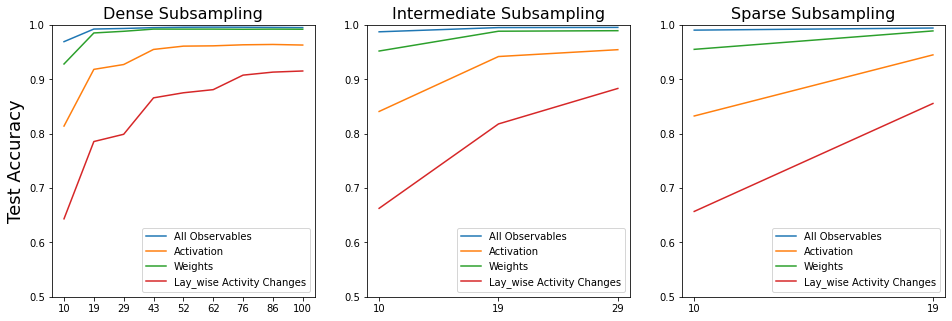

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

def setXlabel(traj_list):
  x_forshow = []
  i = 0
  for num in num_sample:
    if num<=len(traj_list):
      x_forshow.append(round(num/len(traj_origin)*100))
      i += 1
  return x_forshow

def setXValue(out_acc):
  x_value = []
  for acc in out_acc['all']:
    x_value.append(out_acc['all'].index(acc))
    
  return x_value

x_dense_forshow = setXlabel(traj_dense)
x_dense_value = setXValue(cls_out_test_acc_dense)
x_inter_forshow = setXlabel(traj_inter)
x_inter_value = setXValue(cls_out_test_acc_inter)
x_sparse_forshow = setXlabel(traj_sparse)
x_sparse_value = setXValue(cls_out_test_acc_sparse)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
ax[0].plot(cls_out_test_acc_dense['all'], label = "All Observables")
ax[0].plot(cls_out_test_acc_dense['act'], label = "Activation")
ax[0].plot(cls_out_test_acc_dense['weight'], label = "Weights")
ax[0].plot(cls_out_test_acc_dense['grad'], label = "Lay_wise Activity Changes")
ax[0].set_ylim(0.5, 1.0)
ax[0].set_title("Dense Subsampling", fontsize=16)
ax[0].set_xticks(x_dense_value)
ax[0].set_xticklabels(x_dense_forshow)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Test Accuracy", fontsize=18)

ax[1].plot(cls_out_test_acc_inter['all'], label = "All Observables")
ax[1].plot(cls_out_test_acc_inter['act'], label = "Activation")
ax[1].plot(cls_out_test_acc_inter['weight'], label = "Weights")
ax[1].plot(cls_out_test_acc_inter['grad'], label = "Lay_wise Activity Changes")
ax[1].set_ylim(0.5, 1.0)
ax[1].set_title("Intermediate Subsampling", fontsize=16)
ax[1].set_xticks(x_inter_value)
ax[1].set_xticklabels(x_inter_forshow)
ax[1].legend(loc="lower right")

ax[2].plot(cls_out_test_acc_sparse['all'], label = "All Observables")
ax[2].plot(cls_out_test_acc_sparse['act'], label = "Activation")
ax[2].plot(cls_out_test_acc_sparse['weight'], label = "Weights")
ax[2].plot(cls_out_test_acc_sparse['grad'], label = "Lay_wise Activity Changes")
ax[2].set_ylim(0.5, 1.0)
ax[2].set_title("Sparse Subsampling", fontsize=16)
ax[2].set_xticks(x_sparse_value)
ax[2].set_xticklabels(x_sparse_forshow)
ax[2].legend(loc="lower right")
